In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True

In [2]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 데이터셋 위치
data_dir1 = '../../pretrained_GNN/dataset/fruit_fresh_and_rotten_dataset'
data_dir2 = '../../pretrained_GNN/dataset/fruit_quality'
data_dir3 = '../../pretrained_GNN/dataset/fruit_quality2'

# 데이터셋 정제
image_datasets1 = {x: datasets.ImageFolder(os.path.join(data_dir1, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
image_datasets2 = {x: datasets.ImageFolder(os.path.join(data_dir2, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
image_datasets3 = {x: datasets.ImageFolder(os.path.join(data_dir3, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders1 = {x: torch.utils.data.DataLoader(image_datasets1[x], batch_size=32,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataloaders2 = {x: torch.utils.data.DataLoader(image_datasets2[x], batch_size=32,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataloaders3 = {x: torch.utils.data.DataLoader(image_datasets3[x], batch_size=32,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}


dataset_sizes1 = {x: len(image_datasets1[x]) for x in ['train', 'val']}
dataset_sizes2 = {x: len(image_datasets2[x]) for x in ['train', 'val']}
dataset_sizes3 = {x: len(image_datasets3[x]) for x in ['train', 'val']}


class_names1 = image_datasets1['train'].classes
class_names2 = image_datasets2['train'].classes
class_names3 = image_datasets3['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
print(len(class_names1), len(class_names2), len(class_names3))

6 12 2


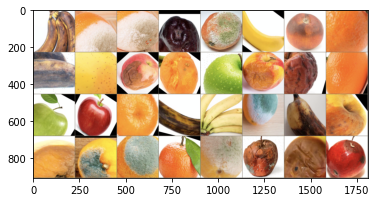

['rottenbanana', 'rottenoranges', 'rottenoranges', 'rottenapples', 'rottenoranges', 'freshbanana', 'rottenapples', 'freshoranges', 'rottenbanana', 'freshapples', 'rottenapples', 'rottenoranges', 'freshapples', 'rottenapples', 'rottenapples', 'freshoranges', 'freshapples', 'freshapples', 'freshoranges', 'rottenbanana', 'freshbanana', 'rottenoranges', 'rottenbanana', 'rottenapples', 'rottenapples', 'rottenoranges', 'rottenoranges', 'freshoranges', 'rottenoranges', 'rottenapples', 'rottenapples', 'rottenapples']


In [4]:
# transform 된 배치 이미지 시각화
def imshow1(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders1['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow1(out)
print([class_names1[x] for x in classes])

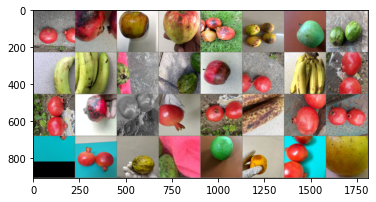

['Pomegranate_Good', 'Pomegranate_Bad', 'Apple_Bad', 'Apple_Bad', 'Pomegranate_Bad', 'Lime_Bad', 'Apple_Good', 'Guava_Good', 'Banana_Good', 'Banana_Good', 'Guava_Good', 'Guava_Good', 'Apple_Bad', 'Pomegranate_Good', 'Banana_Good', 'Pomegranate_Good', 'Pomegranate_Good', 'Pomegranate_Bad', 'Pomegranate_Good', 'Pomegranate_Good', 'Pomegranate_Good', 'Banana_Bad', 'Pomegranate_Good', 'Pomegranate_Good', 'Pomegranate_Good', 'Pomegranate_Good', 'Guava_Bad', 'Guava_Good', 'Apple_Good', 'Orange_Bad', 'Pomegranate_Good', 'Apple_Good']


In [5]:
# transform 된 배치 이미지 시각화
def imshow2(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders2['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow2(out)
print([class_names2[x] for x in classes])

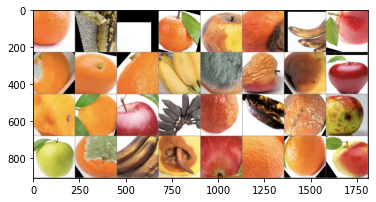

['fresh', 'rotten', 'fresh', 'fresh', 'rotten', 'rotten', 'rotten', 'fresh', 'rotten', 'fresh', 'fresh', 'fresh', 'rotten', 'rotten', 'rotten', 'fresh', 'rotten', 'fresh', 'fresh', 'rotten', 'rotten', 'rotten', 'rotten', 'rotten', 'fresh', 'rotten', 'rotten', 'rotten', 'fresh', 'fresh', 'fresh', 'fresh']


In [6]:
# transform 된 배치 이미지 시각화
def imshow3(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders3['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow1(out)
print([class_names3[x] for x in classes])

In [7]:
# 미리 학습된 resnet 모델 불러오기
model_ft = models.efficientnet_b0(pretrained=True)
model_ft = model_ft.to(device)

# print(model_ft)
# 1/0
# 마지막 연결계층의 입력부분까지 받아오기 > 완전계층 이후 부분은 학습
num_ftrs = model_ft.classifier[1].in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.classifier[1] = nn.Linear(num_ftrs, len (class_names1))
model_ft.classifier = model_ft.classifier.to(device)

print(model_ft)
# 1/0
criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [8]:
from torchsummary import summary

summary(model_ft, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [9]:
from tqdm import tqdm

def train_model1(model, criterion, optimizer, scheduler, num_epochs=25):
    model = model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())      # 모델 학습파라미터 불러와서 카피
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 배치크기로 반복해서 불러옴
            for inputs, labels in dataloaders1[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes1[phase]
            epoch_acc = running_corrects.double() / dataset_sizes1[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함, 값 갱신
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        time.sleep(0.1)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [11]:
import gc
gc.collect()
torch.cuda.empty_cache()

train_model1(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 0.6038 Acc: 0.8404


  5%|▌         | 1/20 [01:24<26:50, 84.76s/it]

val Loss: 0.1006 Acc: 0.9774

Epoch 1/19
----------
train Loss: 0.1852 Acc: 0.9429


 10%|█         | 2/20 [02:46<24:57, 83.20s/it]

val Loss: 0.0573 Acc: 0.9852

Epoch 2/19
----------
train Loss: 0.1198 Acc: 0.9646


 15%|█▌        | 3/20 [04:09<23:30, 82.97s/it]

val Loss: 0.0300 Acc: 0.9896

Epoch 3/19
----------
train Loss: 0.0984 Acc: 0.9709


 20%|██        | 4/20 [05:32<22:09, 83.11s/it]

val Loss: 0.0247 Acc: 0.9922

Epoch 4/19
----------
train Loss: 0.0973 Acc: 0.9693


 25%|██▌       | 5/20 [06:51<20:24, 81.62s/it]

val Loss: 0.0147 Acc: 0.9959

Epoch 5/19
----------
train Loss: 0.0831 Acc: 0.9730


 30%|███       | 6/20 [08:14<19:07, 81.99s/it]

val Loss: 0.0174 Acc: 0.9956

Epoch 6/19
----------
train Loss: 0.0693 Acc: 0.9776


 30%|███       | 6/20 [09:36<22:24, 96.05s/it]


KeyboardInterrupt: 

In [12]:
model_ft = models.efficientnet_b0(pretrained=True)
model_ft = model_ft.to(device)

# print(model_ft)
# 1/0
# 마지막 연결계층의 입력부분까지 받아오기 > 완전계층 이후 부분은 학습
num_ftrs = model_ft.classifier[1].in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.classifier[1] = nn.Linear(num_ftrs, len (class_names2))
model_ft.classifier = model_ft.classifier.to(device)

# print(model_ft)

summary(model_ft, (3, 224, 224))

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [13]:
from tqdm import tqdm

def train_model2(model, criterion, optimizer, scheduler, num_epochs=25):
    model = model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())      # 모델 학습파라미터 불러와서 카피
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 배치크기로 반복해서 불러옴
            for inputs, labels in dataloaders2[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes2[phase]
            epoch_acc = running_corrects.double() / dataset_sizes2[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함, 값 갱신
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        time.sleep(0.1)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [14]:
import gc
gc.collect()
torch.cuda.empty_cache()

train_model2(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 0.8981 Acc: 0.7790


  5%|▌         | 1/20 [03:57<1:15:05, 237.15s/it]

val Loss: 0.3377 Acc: 0.9066

Epoch 1/19
----------
train Loss: 0.2575 Acc: 0.9294


 10%|█         | 2/20 [07:53<1:11:05, 236.95s/it]

val Loss: 0.2201 Acc: 0.9288

Epoch 2/19
----------
train Loss: 0.1715 Acc: 0.9516


 15%|█▌        | 3/20 [11:51<1:07:11, 237.13s/it]

val Loss: 0.1760 Acc: 0.9415

Epoch 3/19
----------
train Loss: 0.1434 Acc: 0.9576


 20%|██        | 4/20 [15:48<1:03:16, 237.27s/it]

val Loss: 0.1608 Acc: 0.9429

Epoch 4/19
----------
train Loss: 0.1289 Acc: 0.9616


 25%|██▌       | 5/20 [19:47<59:27, 237.81s/it]  

val Loss: 0.1743 Acc: 0.9334

Epoch 5/19
----------
train Loss: 0.1120 Acc: 0.9648


 30%|███       | 6/20 [23:44<55:24, 237.47s/it]

val Loss: 0.1806 Acc: 0.9312

Epoch 6/19
----------
train Loss: 0.0960 Acc: 0.9710


 35%|███▌      | 7/20 [27:40<51:21, 237.04s/it]

val Loss: 0.1781 Acc: 0.9291

Epoch 7/19
----------
train Loss: 0.0975 Acc: 0.9699


 40%|████      | 8/20 [31:36<47:22, 236.84s/it]

val Loss: 0.1774 Acc: 0.9321

Epoch 8/19
----------
train Loss: 0.0921 Acc: 0.9725


 45%|████▌     | 9/20 [35:55<44:39, 243.55s/it]

val Loss: 0.1718 Acc: 0.9350

Epoch 9/19
----------
train Loss: 0.0938 Acc: 0.9702


 50%|█████     | 10/20 [40:14<41:24, 248.47s/it]

val Loss: 0.1775 Acc: 0.9345

Epoch 10/19
----------
train Loss: 0.0873 Acc: 0.9730


 55%|█████▌    | 11/20 [44:26<37:26, 249.63s/it]

val Loss: 0.1803 Acc: 0.9321

Epoch 11/19
----------
train Loss: 0.0899 Acc: 0.9718


 60%|██████    | 12/20 [48:18<32:33, 244.16s/it]

val Loss: 0.1860 Acc: 0.9285

Epoch 12/19
----------
train Loss: 0.0848 Acc: 0.9739


 65%|██████▌   | 13/20 [52:09<28:00, 240.13s/it]

val Loss: 0.1963 Acc: 0.9291

Epoch 13/19
----------
train Loss: 0.0889 Acc: 0.9732


 70%|███████   | 14/20 [56:02<23:48, 238.06s/it]

val Loss: 0.1755 Acc: 0.9302

Epoch 14/19
----------
train Loss: 0.0849 Acc: 0.9745


 75%|███████▌  | 15/20 [59:53<19:39, 235.99s/it]

val Loss: 0.1913 Acc: 0.9258

Epoch 15/19
----------
train Loss: 0.0897 Acc: 0.9726


 80%|████████  | 16/20 [1:03:45<15:39, 234.79s/it]

val Loss: 0.1715 Acc: 0.9350

Epoch 16/19
----------
train Loss: 0.0824 Acc: 0.9736


 85%|████████▌ | 17/20 [1:07:29<11:34, 231.35s/it]

val Loss: 0.1870 Acc: 0.9277

Epoch 17/19
----------
train Loss: 0.0845 Acc: 0.9750


 90%|█████████ | 18/20 [1:11:17<07:40, 230.28s/it]

val Loss: 0.1818 Acc: 0.9299

Epoch 18/19
----------
train Loss: 0.0872 Acc: 0.9732


 95%|█████████▌| 19/20 [1:15:07<03:50, 230.42s/it]

val Loss: 0.1598 Acc: 0.9413

Epoch 19/19
----------
train Loss: 0.0899 Acc: 0.9718


100%|██████████| 20/20 [1:18:58<00:00, 236.93s/it]

val Loss: 0.1718 Acc: 0.9356

Training complete in 78m 59s
Best val Acc: 0.942880


EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [15]:
model_ft = models.efficientnet_b0(pretrained=True)
model_ft = model_ft.to(device)

# print(model_ft)
# 1/0
# 마지막 연결계층의 입력부분까지 받아오기 > 완전계층 이후 부분은 학습
num_ftrs = model_ft.classifier[1].in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.classifier[1] = nn.Linear(num_ftrs, len (class_names3))
model_ft.classifier = model_ft.classifier.to(device)

# print(model_ft)

summary(model_ft, (3, 224, 224))

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [16]:
from tqdm import tqdm

def train_model3(model, criterion, optimizer, scheduler, num_epochs=25):
    model = model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())      # 모델 학습파라미터 불러와서 카피
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 배치크기로 반복해서 불러옴
            for inputs, labels in dataloaders3[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes3[phase]
            epoch_acc = running_corrects.double() / dataset_sizes2[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함, 값 갱신
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        time.sleep(0.1)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [17]:
import gc
gc.collect()
torch.cuda.empty_cache()

train_model3(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 0.2481 Acc: 0.6682


  5%|▌         | 1/20 [01:30<28:36, 90.36s/it]

val Loss: 0.0672 Acc: 1.4472

Epoch 1/19
----------
train Loss: 0.1122 Acc: 0.7076


 10%|█         | 2/20 [02:56<26:21, 87.87s/it]

val Loss: 0.0307 Acc: 1.4637

Epoch 2/19
----------


 10%|█         | 2/20 [03:38<32:42, 109.00s/it]


KeyboardInterrupt: 

In [2]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 데이터셋 위치
data_dir = '../../pretrained_GNN/dataset/FruitAndVegetables'


# 데이터셋 정제
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
from torchsummary import summary

model_ft = models.efficientnet_b0(pretrained=True)
model_ft = model_ft.to(device)

# print(model_ft)
# 1/0
# 마지막 연결계층의 입력부분까지 받아오기 > 완전계층 이후 부분은 학습
num_ftrs = model_ft.classifier[1].in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.classifier[1] = nn.Linear(num_ftrs, len (class_names))
model_ft.classifier = model_ft.classifier.to(device)

# print(model_ft)

summary(model_ft, (3, 224, 224))

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [11]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    model = model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())      # 모델 학습파라미터 불러와서 카피
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 배치크기로 반복해서 불러옴
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함, 값 갱신
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        time.sleep(0.001)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [12]:
import gc
gc.collect()
torch.cuda.empty_cache()

train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 3.3800 Acc: 0.1701


  5%|▌         | 1/20 [01:04<20:27, 64.61s/it]

val Loss: 2.8337 Acc: 0.6017

Epoch 1/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.6702 Acc: 0.5358


 10%|█         | 2/20 [02:07<19:04, 63.59s/it]

val Loss: 1.8259 Acc: 0.7465

Epoch 2/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 1.9422 Acc: 0.6398


 15%|█▌        | 3/20 [03:09<17:49, 62.91s/it]

val Loss: 1.1299 Acc: 0.8078

Epoch 3/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 1.4849 Acc: 0.6925


 20%|██        | 4/20 [04:11<16:38, 62.39s/it]

val Loss: 0.7727 Acc: 0.8496

Epoch 4/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 1.1677 Acc: 0.7319


 25%|██▌       | 5/20 [05:13<15:37, 62.51s/it]

val Loss: 0.5739 Acc: 0.8802

Epoch 5/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.9720 Acc: 0.7663


 30%|███       | 6/20 [06:17<14:38, 62.74s/it]

val Loss: 0.4646 Acc: 0.8997

Epoch 6/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8901 Acc: 0.7782


 35%|███▌      | 7/20 [07:20<13:38, 62.97s/it]

val Loss: 0.4025 Acc: 0.8914

Epoch 7/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8388 Acc: 0.7817


 40%|████      | 8/20 [08:22<12:30, 62.56s/it]

val Loss: 0.3968 Acc: 0.8997

Epoch 8/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8283 Acc: 0.7936


 45%|████▌     | 9/20 [09:23<11:25, 62.31s/it]

val Loss: 0.3940 Acc: 0.9025

Epoch 9/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8001 Acc: 0.7974


 50%|█████     | 10/20 [10:25<10:22, 62.21s/it]

val Loss: 0.3782 Acc: 0.9081

Epoch 10/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.7844 Acc: 0.7958


 55%|█████▌    | 11/20 [11:28<09:20, 62.29s/it]

val Loss: 0.3807 Acc: 0.9136

Epoch 11/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.7887 Acc: 0.7929


 60%|██████    | 12/20 [12:30<08:17, 62.24s/it]

val Loss: 0.3738 Acc: 0.9109

Epoch 12/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.7636 Acc: 0.7984


 65%|██████▌   | 13/20 [13:30<07:11, 61.68s/it]

val Loss: 0.3653 Acc: 0.9220

Epoch 13/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.7685 Acc: 0.7990


 70%|███████   | 14/20 [14:32<06:09, 61.66s/it]

val Loss: 0.3663 Acc: 0.9192

Epoch 14/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.7727 Acc: 0.7955


 75%|███████▌  | 15/20 [15:36<05:11, 62.25s/it]

val Loss: 0.3626 Acc: 0.9136

Epoch 15/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.7645 Acc: 0.8035


 80%|████████  | 16/20 [16:39<04:09, 62.45s/it]

val Loss: 0.3535 Acc: 0.9164

Epoch 16/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.7795 Acc: 0.7965


 85%|████████▌ | 17/20 [17:43<03:09, 63.09s/it]

val Loss: 0.3678 Acc: 0.9192

Epoch 17/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.7566 Acc: 0.8042


 90%|█████████ | 18/20 [18:47<02:06, 63.36s/it]

val Loss: 0.3625 Acc: 0.9164

Epoch 18/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.7832 Acc: 0.7888


 95%|█████████▌| 19/20 [19:49<01:03, 63.03s/it]

val Loss: 0.3531 Acc: 0.9192

Epoch 19/19
----------


/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/anaconda3/envs/geo/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.7483 Acc: 0.8077


100%|██████████| 20/20 [20:51<00:00, 62.56s/it]

val Loss: 0.3514 Acc: 0.9192

Training complete in 20m 51s
Best val Acc: 0.922006


EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 